# Quickstart Guide: The Basics

---

Okay, I've installed ``cluster_generator`` and I want to start making clusters for my simulation project... How do I start? This guide will show you the ropes as far as using ``cluster_generator`` to build you galaxy cluster models!

## Contents

- [Building the Foundation: Profiles](#Building-The-Foundation)
- [Raising the Frame: Cluster Models](#Raising-The-Frame)
- [Finishing the House: Cluster ICs](#Finishing-The-House)

## Building The Foundation

---

<div class="alert alert-block alert-info">
<p><b> &#128161; Big Ideas:</b></p> 
Profiles are the underpinning of all of the systems you can build in <tt>cluster_generator</tt>. Before you can build a galaxy cluster, you have to select the profiles you're going to provide in order to make the system.
</div>

There are a variety of radial profiles available in <tt>cluster_generator</tt>, which you can find on the [Radial Profiles page](https://eliza-diggins.github.io/cluster_generator/build/html/radial_profiles.html#radial-profiles) of the documentation. Each of these ``RadialProfile`` objects is really just a fancy wrapper for a simple function. Let's see an example:
<br>
<br>

In [1]:
# -- Imports -- #
import cluster_generator as cg

# -- building the profile -- #
example_profile = cg.radial_profiles.hernquist_density_profile(1e10,300) # Create a Hernquist Profile

print(example_profile, example_profile(100))

RadialProfile; type=hernquist_density_profile. 74.60387957432596


<br>
<br>

Notice that the ``example_profile`` is its own type, but is also callable? The basic construction of ``RadialProfile`` objects is as a wrapper for simple lambda functions. In fact, you can make your own radial profiles by simply supplying a lambda function to the ``RadialProfile`` class. 

There really isn't a whole lot to the ``RadialProfiles``, but they're really important. The important things to remember are as follows:


<div class="alert alert-block alert-warning">
<p><b> &#128161; Things To Remember:</b></p> 
<ul>
<li> <tt>RadialProfiles</tt> are <b>not unit-ed</b>. This means you need to follow standard conventions for units (Myr, kpc, Solar Masses).</li>
<li> <tt>RadialProfiles</tt> can be saved to a binary format (using the <tt>.to_binary</tt> method).</li>
<li> <tt>RadialProfiles</tt> can have cores added or be truncated if needed (<tt>.cutoff</tt> and <tt>.add_core</tt> respectively).</li>
<li> <tt>RadialProfiles</tt> can be plotted using the <tt>.plot</tt> method.</li>
</ul>
</div>

We won't go into to much detail about ``RadialProfile`` objects here, if you're interested in knowing more, see the [api documentation](http://localhost:63342/cluster_generator/docs/build/html/_as_gen/radial_profiles.html). For now, let's start by defining the basic profiles we're going to use to build our cluster:

<div class="alert alert-block alert-warning">
<p><b> &#128161; Alert:</b></p> 
You don't need the <tt>colossus</tt> package to use <tt>cluster_generator</tt>; however, we will mention here that <tt>colossus</tt> has many utilities that are useful for generating well chosen radial profiles for your clusters. 
</div>

In [2]:
# -- building the cluster profiles -- #
from colossus.halo import concentration
from colossus.cosmology import cosmology
from yt.utilities.cosmology import Cosmology

# -- Setting Cosmology Parameters (OPTIONAL) -- #
ccosmo = cosmology.setCosmology("planck18")
cosmo = Cosmology(
    hubble_constant=ccosmo.h, omega_matter=ccosmo.Om0, omega_lambda=ccosmo.Ode0
)
z = 0.546 # --> set the redshift

# -- Building the Cluster -- #

m200 = 1.1e15*1.23 # --> Set the mass

conc = concentration.modelDiemer19(m200/ccosmo.h,z)[0] # Uses the concentration - mass relation to find the right concentration parameter
r200 = cg.find_overdensity_radius(m200,200.0,z=z,cosmo=cosmo)

rs = r200/conc
rt = r200*2
# Building the profiles #
Mt = cg.tnfw_mass_profile(cg.nfw_scale_density(conc,z=z), rs, rt)

Let's take a look at what we just made:

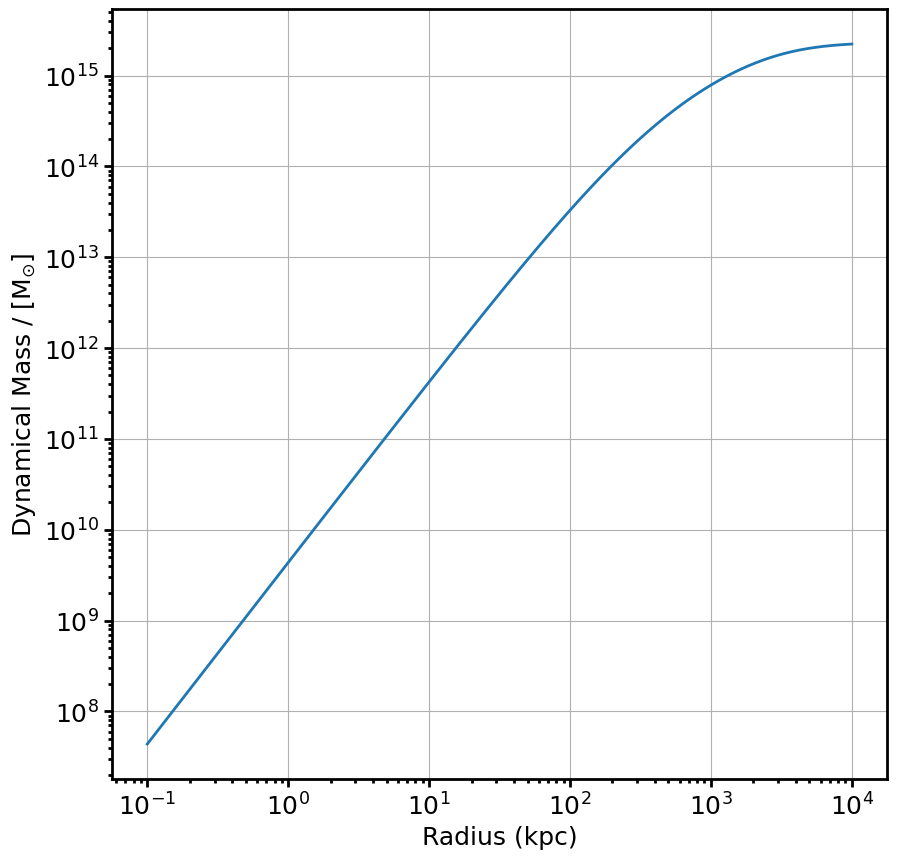

In [3]:
import matplotlib.pyplot as plt
Mt.plot(0.1,10000,1000)
plt.ylabel("Dynamical Mass / [$\mathrm{M_{\odot}}$]")
plt.grid()
plt.show()

For the next session, we are also going to need a gas-mass profile, so let's see how to build that really quick!

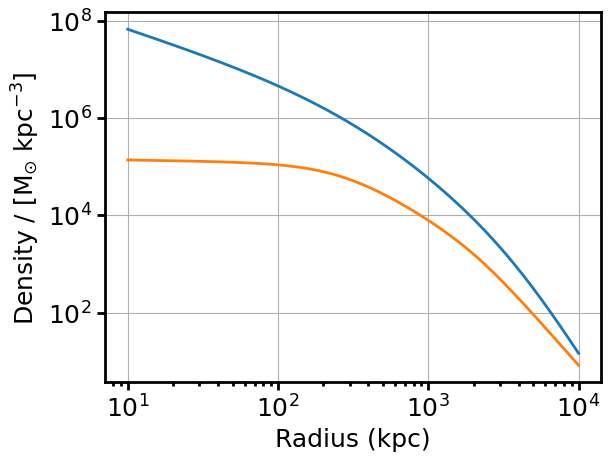

In [4]:
# -- Constructing the density profiles for later -- #
f_g = 0.115 # --> this is the gas fraction

# -- Build the total density -- #
rhot = cg.tnfw_density_profile(cg.nfw_scale_density(conc,z=z), rs, rt) # --> converting the mass profile above to a density profile.

# -- Building the gas density -- #
r2500,_ = cg.find_radius_mass(Mt,z=z,delta=2500.0,cosmo=cosmo) # --> Find r2500 for the total cluster.
rhog = cg.vikhlinin_density_profile(1.0, 0.5 * r2500, 1.1 * r200, 0.1, 0.67, 3) # --> Use r2500 and r200 to build a profile.
rhog = cg.rescale_profile_by_mass(rhog, f_g * m200, r200) # --> Rescale so that it has the right gas fraction.

fig,ax = plt.subplots(1,1)

rhot.plot(1e1,1e4,1000,fig=fig,ax=ax)
rhog.plot(1e1,1e4,1000,fig=fig,ax=ax)
plt.grid()
plt.ylabel("Density / $[\mathrm{M_{\odot} \; kpc^{-3}}]$")
plt.show()

## Raising The Frame

---

<div class="alert alert-block alert-info">
<p><b> &#128161; Big Ideas:</b></p> 
While <tt>RadialProfiles</tt> represent the data from which we want to construct a self-consistent system, the <tt>ClusterModel</tt> class represents the realization of a fully constructed galaxy cluster.
</div>

So far, we've seen how to make the <tt>RadialProfile</tt> objects that we want to use to build galaxy clusters. Now, we're ready to pull it all together. In <tt>cluster_generator</tt>, the [<tt>ClusterModel</tt>](https://eliza-diggins.github.io/cluster_generator/build/html/models.html) class is the realization of a complete galaxy cluster. All of these instances are predicated on <u>hydrostatic equilibrium</u>. There are a variety of ways to generate these objects directly from profiles; however, here we are going to use only the dynamical density and the gas density to produce our cluster.

In [5]:
# Turning off spinners because Jupyter notebooks don't render them properly.
from cluster_generator.utils import cgparams
cgparams["system"]["text"]["spinners"] = False

model = cg.ClusterModel.from_dens_and_tden(0.1, 15000.0, rhog, rhot)

cluster_generator : [INFO     ] 2023-09-10 09:57:30,876 Computing the profiles from density and total density. Gravity=Newtonian
cluster_generator : [INFO     ] 2023-09-10 09:57:30,878 Integrating total mass profile.
cluster_generator : [INFO     ] 2023-09-10 09:57:31,101 ClusterModel [ClusterModel object; gravity=Newtonian] has no virialization method. Setting to default = eddington
cluster_generator : [INFO     ] 2023-09-10 09:57:31,102 Computing gravitational potential of ClusterModel object; gravity=Newtonian. gravity=Newtonian.
cluster_generator : [INFO     ] 2023-09-10 09:57:32,215 Integrating pressure profile.
		[from_scratch]: Sun Sep 10 09:57:38 2023 Checking for missing mass / density fields...[DONE]
		[from_scratch]: Sun Sep 10 09:57:38 2023 Determining the halo component...[DONE]
		[from_scratch]: Sun Sep 10 09:57:38 2023 Computing additional fields...[DONE]
		[from_scratch]: Sun Sep 10 09:57:38 2023 Initializing the ClusterModel...


Okay, so a lot of things appear to have happened! For a complete picture of what all of these logging calls mean, see the [data structures guide](https://eliza-diggins.github.io/cluster_generator/build/html/notebooks/api_guides/1.html). The important parts of this from the user's perspective are as follows:

- [Line 1]: Tells us that we are building the profiles using <u>density and total density</u> and that our gravity is <u>Newtonian</u>. 
- [Line 2]: Says that there is <u>no virialization method</u> so it selects ``eddington`` as the virialization method. 

For the most part, general usage won't require the user paying much attention to these two options. Typically, ``eddington`` is the best option for virialization and ``Newtonian`` is the standard gravity. A more comprehensive account of the different gravities and virialization methods can be found in other, more complex, guides.

Let's look at what's actually here:

In [6]:
print(model)

ClusterModel object; gravity=Newtonian, fields=['radius', 'density', 'total_density', 'total_mass', 'gas_mass', 'stellar_density', 'gravitational_potential', 'gravitational_field', 'pressure', 'temperature', 'dark_matter_density', 'dark_matter_mass', 'gas_fraction', 'electron_number_density', 'entropy']


So when we print the <tt>ClusterModel</tt> object, we see that it's using Newtonian gravity and has a long list of fields.

<div class="alert alert-block alert-success">
<p><b> &#128161; Fields:</b></p> 
Many of the data structures in <tt>cluster_generator</tt>, and in similar projects like <tt>yt</tt> are focused around so called <tt>fields</tt>. Each <tt>field</tt> is essentially an array containing the pertinent data for that particular quantity. In this case, each <tt>field</tt> in a <tt>ClusterModel</tt> instances is just a 1D array containing the radial profile for that quantity. The big takeaway is that when a <tt>ClusterModel</tt> is generated, the behind-the-scenes machinery will use the profiles the user provided to build all of the other useful / interesting data.
</div>
<br>
<br>

Let's take a look at some of the features we can take advantage of with ``ClusterModel`` instances.<br>
The first thing to know is that we can plot any of the fields we're interested in:

<br>
<br>

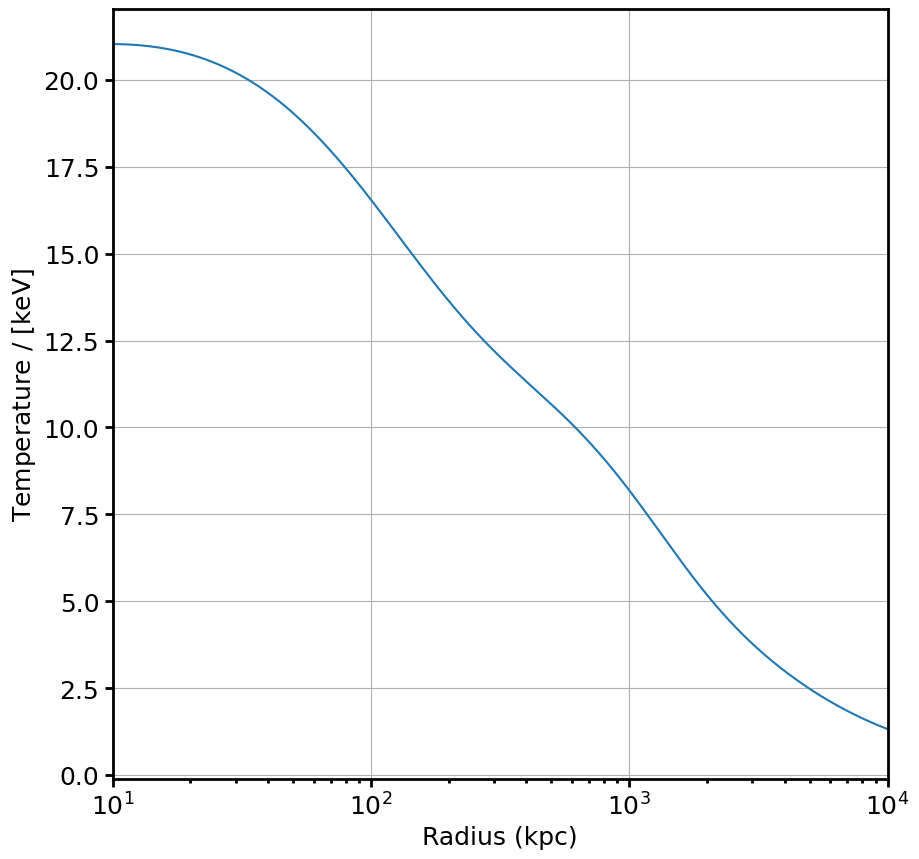

In [7]:
model.plot("temperature",10,1e4)
plt.yscale("linear")
plt.ylabel("Temperature / [$\mathrm{keV}$]")
plt.grid()
plt.show()

There are two other <u>extremely useful</u> things you can get from the <tt>ClusterModel</tt> instance: the physicality, and the HSE quality. Let's start by looking at HSE. Every galaxy cluster is assumed to follow HSE, and therefore it is a good check on the code to make sure that your cluster is actually equilibrated properly. To check this,

In [8]:
c = model.check_hse()

cluster_generator : [INFO     ] 2023-09-10 09:57:38,545 The maximum relative deviation of this profile from hydrostatic equilibrium is 0.00110331


So we see that the cluster is in hydrostatic equilibrium to 1 part in about 1000. 

<div class="alert alert-block alert-info">
<p><b> &#9989; Common Sense Test:</b></p> 
This is a really easy check to always build into your initialization system. Clusters should always be in HSE unless your intention is specifically to prevent them from being in HSE.
</div>

We can also check that the cluster is physically consistent (i.e. no negative densities, negative temperatures, etc.). To do so, we use the following

In [9]:
u = model.is_physical()
print(f"The model is physical? {u[0]}")

✔ cluster_generator : [INFO     ] Sun Sep 10 09:57:38 2023 Checking physicality ⠙ luster_generator : [INFO     ] Sun Sep 10 09:57:38 2023 Checking physicality o ClusterModel object; gravity=Newtonian is physical.


The model is physical? True


<br>
<br>
<div class="alert alert-block alert-info">
<p><b> &#10067; Why Physicality?</b></p> 
    While this cluster is intrinsically self-consistent, some clusters may be generated with profiles which are not actually self consistent over their domain. This can lead to non-physical behaviors in some of the derived fields. 
</div>

## Finishing The House

---

Okay, we've seen how to make self-consistent galaxy clusters using <tt>cluster_generator</tt>, we're ready to pull things all together. In this section, we're going to see the ``ClusterICs`` class, which can contain one or more cluster models and is the class which joins the code-specific frontends with the base code of the <tt>cluster_generator</tt> library. Making one is simple:

In [10]:
# -- Saving the model to file -- #
model.write_model_to_h5("basic_model.h5",overwrite=True)

# -- Building the IC -- #
ic = cg.ClusterICs("ic_example",1,["basic_model.h5"],[[0,0,0]],[[0,0,0]],{"dm":100_000})

print(ic)

cluster_generator : [INFO     ] 2023-09-10 09:57:38,695 Loading ClusterModel instance from basic_model.h5.


<br>
<br>

Okay, so we've successfully built the initial conditions object. It's worth noting that these objects can accomodate an arbitrary number of clusters at once, which allows you to generate merger scenarios. In this guide, we're really only interested in 2 functionalities of the initial conditions object. The first is that it can be converted into a <tt>yt</tt> dataset using the <tt>.create_dataset</tt> method. The second is that we can use these objects to interact directly with the front-end. For example, if we want to create RAMSES style initial conditions, we need only run

In [11]:
from cluster_generator.codes import setup_ramses_ics
setup_ramses_ics(ic)

cluster_generator : [INFO     ] 2023-09-10 09:57:38,729 Loading ClusterModel instance from basic_model.h5.
cluster_generator : [INFO     ] 2023-09-10 09:57:38,755 Loading ClusterModel instance from basic_model.h5.


Computing particle DF (Eddington) :   0%|          | 0/1000 [00:00<?, ?it/s]

cluster_generator : [INFO     ] 2023-09-10 09:57:39,915 We will be assigning 100000 dark_matter particles.
cluster_generator : [INFO     ] 2023-09-10 09:57:39,916 Compute 100000 particle positions.
cluster_generator : [INFO     ] 2023-09-10 09:57:39,944 Computing dark_matter velocities using eddington method.


Generating particle velocities [Eddington]:   0%|          | 0/100000 [00:00<?, ?it/s]

cluster_generator : [INFO     ] 2023-09-10 09:57:42,778 Simulation setups saved to Merger_Config.txt.


And there you have it; your first initial conditions in <tt>cluster_generator</tt>!